# Web Scraping for Indeed.com Australia and Salary Prediction

##               Model Option 2

This project is a test of three major skills: collecting data by scraping a website, using natural language processing, and building a binary classifier.

Author : Ayesha Khatib

### Import packages

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LassoCV, Lasso, ElasticNetCV, ElasticNet
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [3]:
file = 'jobs_part2_cleanup.csv'
jobs = pd.read_csv(file, index_col=0)

In [4]:
jobs.head(2)

,Job_Title,City,Low_Salary,Hi_Salary,Salary_period,Salary_mean,Job_Title_analyst,Job_Title_data,Job_Title_scientist,Job_Title_business,...,skill_python,skill_spark,skill_hadoop,skill_tableau,skill_r,skill_excel,skill_sas,skill_spss,skill_aws,skill_kafka
Company,,,,,,,,,,,,,,,,,,,,,
The Eclair Group,Junior Data Scientist,Sydney,70000.0,90000.0,year,80000.0,0.0,0.363327,0.478627,0.0,...,0,0,0,0,1,0,0,0,0,0
Intellify,Junior data scientist/machine learning engineer,Sydney,80000.0,100000.0,year,90000.0,0.0,0.219006,0.288505,0.0,...,0,0,0,0,1,1,0,0,0,0


### Exploratory Data Analysis (EDA)

In [5]:
#Let's begin by looking at the summary statistics
jobs.describe()

,Low_Salary,Hi_Salary,Salary_mean,Job_Title_analyst,Job_Title_data,Job_Title_scientist,Job_Title_business,Job_Title_senior,Job_Title_engineer,Job_Title_manager,...,skill_python,skill_spark,skill_hadoop,skill_tableau,skill_r,skill_excel,skill_sas,skill_spss,skill_aws,skill_kafka
count,104.000000,104.000000,104.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,...,516.000000,516.000000,516.000000,516.000000,516.0,516.000000,516.000000,516.000000,516.000000,516.000000
mean,103733.163462,117485.653846,110609.408654,0.141564,0.120068,0.079421,0.065005,0.054612,0.025813,0.024785,...,0.284884,0.087209,0.071705,0.158915,1.0,0.527132,0.164729,0.015504,0.032946,0.017442
std,44653.524692,48356.641265,46006.577181,0.168572,0.212253,0.210780,0.185122,0.156650,0.110043,0.101622,...,0.451797,0.282415,0.258250,0.365951,0.0,0.499748,0.371295,0.123665,0.178668,0.131038
min,32500.000000,34320.000000,33410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,76181.250000,90000.000000,83127.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,95275.000000,110000.000000,103033.500000,0.129272,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
75%,120000.000000,140000.000000,127980.500000,0.230883,0.216634,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
max,260000.000000,312000.000000,280800.000000,1.000000,0.807632,1.000000,0.882079,0.883968,0.865773,0.634374,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


The summary statistics tell us a few things, particularly about salary information. Firstly, that only a minority of our data 
actually has salary information (90 records out of 441 total). This may be a limitation for our modelling and predictions.

However, of the jobs that do list their salary information, a few descriptive statistics of note are apparent. Firstly, the 
average offered salary range for data science/analytics jobs in Australia is 95216 - 112513, with the average mean salary being 103864. Salary varies over a large range though, with the lowest paid jobs paying only 30680, while the highest amount potentially
on offer is 312000.

### Define Target variable.

In [8]:
#Before we can look at distributions for the salary data, we need to limit our rows only to those which have values for salary
jobs_subset = jobs[jobs.Low_Salary.isnull() == False]
jobs_subset.shape

(104, 1042)

In [9]:
#How are the salary variables distributed?
def distribution(values, xlabel, title):
    fig = plt.figure(figsize=(6,4))
    sns.distplot(values, bins = 20,kde=False)
    plt.axvline(x=np.mean(values), linestyle='dashed', color='black', alpha=0.8)
    plt.axvline(x=np.median(values), linestyle='dashed', color = 'r', alpha=0.8)
    plt.ylabel('frequency')
    plt.xlabel(xlabel)
    plt.title(title)

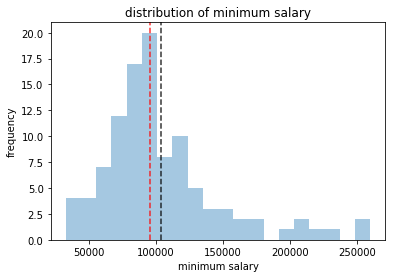

In [10]:
distribution(jobs_subset['Low_Salary'], 'minimum salary', 'distribution of minimum salary')

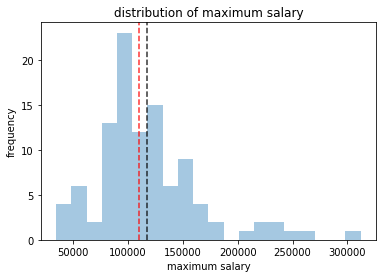

In [11]:
distribution(jobs_subset['Hi_Salary'], 'maximum salary', 'distribution of maximum salary')

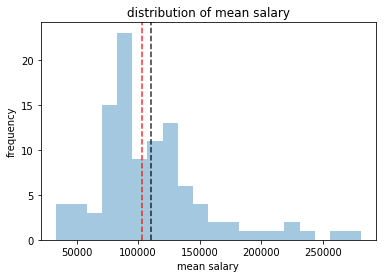

In [12]:
distribution(jobs_subset['Salary_mean'], 'mean salary', 'distribution of mean salary')

Minimum, maximum and mean salary are all somewhat positively skewed. While most of the jobs listed are around the approximately 
100k average, there are a few that are considerably lower and several that are much higher. The distribution of salaries is also
discontinuous, with some gaps where there are no jobs listed in that area. I will attempt linear regression to predict this 
variable but I may have more success if I bin the salary variable into categories and attempt to classify jobs into these 
categories.

Let's look at some boxplots to get a closer look at these outliers.

Text(0, 0.5, 'annual salary (AUD)')

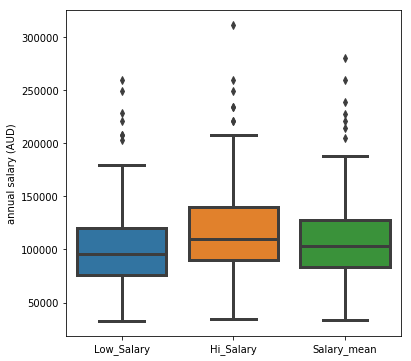

In [14]:
fig = plt.figure(figsize=(6,6))
sns.boxplot(data=jobs_subset[['Low_Salary','Hi_Salary','Salary_mean']],orient='v', linewidth=3)
plt.ylabel('annual salary (AUD)')

The upper range of salaries has more extreme outliers than the other two variables, which makes sense. It's possible that higher-paid jobs have a wider pay range over. I will be considering Mean Salary for the rest of part.

#### Correlations - Heat Map

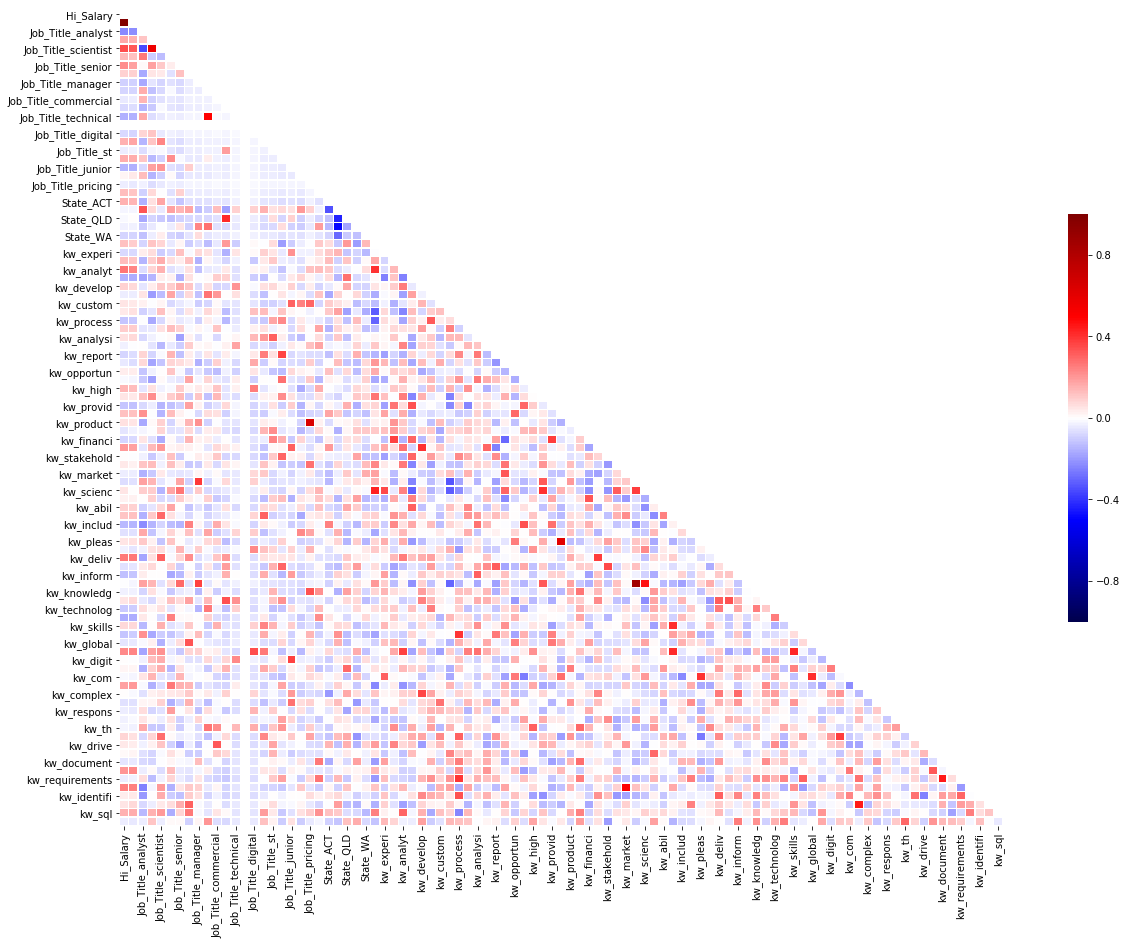

In [15]:
fig = plt.figure(figsize=(20,15))
#Calculate a correlation matrix for the numerical variables
correlations = jobs_subset.iloc[:,3:100].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(correlations, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Make the heatmap
sns.heatmap(correlations, mask = mask, vmin=-1, linewidths=.5, vmax=1, cmap='seismic',cbar_kws={"shrink": .5})

### OBSV :

- Firstly, the states negatively correlate with one another, which is to be expected given that a job is listed in one state only and so these values are mutually exclusive. 

- The salary variables are all strongly collinear, this is also to be expected and will not be an issue as I'll only be using the salary_mean column as a target variable.

### Modelling

What keywords in the job title and job summary predict salary? Does the location affect salary? I will first attempt to construct
a linear model to predict mean salary from these variables.

### Define predictor matrix and target variable

In [17]:
#We'll start by defining a predictor matrix
X = jobs_subset.iloc[:,7:]
#Dropping the columns we found above to be collinear
dropcols = ['kw_machin','kw_environment']
X.drop(dropcols,axis=1,inplace=True)

In [18]:
#And the target variable
y = jobs_subset['Salary_mean']

In [19]:
#Now do a train-test split, leaving 1/3rd of the data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=11)

In [20]:
#Standardize the predictors
ss = StandardScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

D:\ANACONDA\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ANACONDA\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


 ### Model 1 : Linear regression :

I want to see how the model would do with linear regression model before using regularization.

In [21]:
#Fit the training data to a linear regression
lr = LinearRegression()
lr.fit(Xs_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [22]:
#Define a function to get the r2 score for a given model and dataset
def get_r2(model,X,y):
    predictions = model.predict(X)
    r2 = r2_score(y, predictions)
    return r2

In [23]:
#How good is the fit on the training data?
get_r2(lr, Xs_train, y_train)

1.0

In [24]:
#Evaluate the model on test data
get_r2(lr, Xs_test, y_test)

0.01359980491584245

OBSV : The score is very poor and the model doesnot serves the purpose.

### Model 2 : Linear regression with regularization

In [25]:
#Starting with ridge regularization, find the optimal alpha value using CV
ridge = RidgeCV(alphas=np.logspace(0,5,200),cv=10)
ridge.fit(Xs_train,y_train)
bestalpha = ridge.alpha_
bestalpha

D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


1162.322468679853

### Model 3 :Ridge Regularization method

In [26]:
optimalridge = Ridge(alpha = bestalpha)
optimalridge.fit(Xs_train,y_train)

Ridge(alpha=1162.322468679853, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [27]:
#Training r2
get_r2(optimalridge, Xs_train, y_train)

0.6643662534272706

In [28]:
#Testing r2
get_r2(optimalridge, Xs_test, y_test)

0.03565589614194431

OBSV : Ridge regression does not improve the model significantly.

### Model 4 : Lasso Regularization method

In [29]:
#Lasso regularization
lasso = LassoCV(alphas=np.logspace(0,5,200), cv=10)
lasso.fit(Xs_train, y_train)
bestalpha=lasso.alpha_
bestalpha

100000.0

In [30]:
optimallasso = Lasso(alpha = bestalpha)
optimallasso.fit(Xs_train, y_train)

Lasso(alpha=100000.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
#Training r2
get_r2(optimallasso, Xs_train, y_train)

0.0

In [32]:
#Testing r2
get_r2(optimallasso, Xs_test, y_test)

-0.019712708100408927

OBSV: Lasso regression is not doing well either. Perhaps other approaches to feature elimination are needed.

### Conclusion : Linear Regression model with or without regularization methods doesnot perform well and would use other feature-selection and other Classification techniques.

### Feature selection methods :

### K-best method.

In [33]:
#Start with select k-best
select_f = SelectKBest(f_regression, k=10)
select_f.fit(Xs_train, y_train)

D:\ANACONDA\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
D:\ANACONDA\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
D:\ANACONDA\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
D:\ANACONDA\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SelectKBest(k=10, score_func=<function f_regression at 0x000001DAEDC00D08>)

In [34]:
kbest = pd.DataFrame({'feature':list(X_train.columns), 'f_regression score':list(select_f.scores_)})

In [35]:
#What are the highest ranked features for select k best?
kbesttop30 = kbest.sort_values('f_regression score', ascending=False).head(50)
#kbesttop30 = kbesttop30[kbesttop30['f_classif score'] != inf]
kbesttop30

,feature,f_regression score
823,kw_readi,18.887309
61,kw_deliv,12.916108
789,kw_solution,11.913808
538,kw_proactiv,11.308192
147,kw_plan,10.599414
541,kw_subject,10.376605
510,kw_particip,10.112144
655,kw_adapt,9.352323
152,kw_present,9.040868
235,kw_tableau,8.937434


OBSV : Getting a lot of infinite values using select k best, perhaps RFECV will be a better approach.

### RFECV Method :

In [36]:
#Now try RFECV
lr = LinearRegression()
selector = RFECV(lr, step=0.5, cv=10)
selector.fit(Xs_train, y_train)

rfe = pd.DataFrame({'feature':list(X_train.columns),'ranking':list(selector.ranking_),'support':list(selector.support_)})

In [37]:
#We'll also look at the top 10 ranked features for rfe
rfetop30 = rfe.sort_values('ranking',ascending=True).head(30)

In [38]:
#Let's use the features supported by RFECV
rfesupported = rfe[rfe['support']==True]
len(rfesupported)

1

In [39]:
#We could also select features that appear in both lists
combined_features = list(set(kbesttop30.feature).intersection(rfesupported.feature))
print(combined_features)

['kw_environmentstrong']


### Model 5 : Re-try linear modelling after feature elimination

In [40]:
#Define new predictor matrix
Xsub = X[rfesupported.feature]
#Xsub = X[combined_features]
#Xsub = X[kbesttop30.feature]

#I did a lot of trial and error here to decide which set of selected features to use, in the end using the features supported
#by RFECV only yielded the best results.

In [41]:
#New test/train split
Xsub_train, Xsub_test, y_train, y_test = train_test_split(Xsub, y, test_size=0.5, random_state=11)

In [42]:
#Standardize new predictors
ss = StandardScaler()
Xsub_train = ss.fit_transform(Xsub_train)
Xsub_test = ss.transform(Xsub_test)

In [43]:
#Fit on a linear regression model again
lr = LinearRegression()
lr.fit(Xsub_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
#Training r2
get_r2(lr, Xsub_train, y_train)

0.11592927479201032

In [45]:
#Test r2
get_r2(lr, Xsub_test, y_test)

-0.241646076026242

OBSV : Still over-fitted to the training data and maybe if we combine this smaller predictor matrix with regularization we can improve the
test score.

### Model 6 : Linear Regression with Ridge regularization

In [46]:
ridge = RidgeCV(alphas=np.logspace(0,5,200),cv=10)
ridge.fit(Xsub_train,y_train)
bestalpha = ridge.alpha_
optimalridge = Ridge(alpha = bestalpha)
optimalridge.fit(Xsub_train,y_train)

D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [47]:
#r2
print('train r2: ', get_r2(optimalridge, Xsub_train, y_train))
print('test r2: ', get_r2(optimalridge, Xsub_test, y_test))

train r2:  0.11588800413526656
test r2:  -0.23283931938758773


OBSV  Still over-fitting data.

### Model 7 : Linear Regression with Lasso regularization

In [48]:
lasso = LassoCV(alphas=np.logspace(0,5,200), cv=10)
lasso.fit(Xsub_train, y_train)
bestalpha=lasso.alpha_
optimallasso = Lasso(alpha = bestalpha)
optimallasso.fit(Xsub_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [49]:
#r2
print('train r2: ', get_r2(optimallasso, Xsub_train, y_train))
print('test r2: ', get_r2(optimallasso, Xsub_test, y_test))

train r2:  0.1159292742775554
test r2:  -0.2416146700445425


### Model 8 : Linear Regression with Elastic Net regularization

In [50]:
l1_ratios = np.linspace(0.01, 1.0, 25)
elasticnet = ElasticNetCV(l1_ratio = l1_ratios,n_alphas = 200, cv=10)
elasticnet.fit(Xsub_train,y_train)
optimalenet = ElasticNet(alpha = elasticnet.alpha_, l1_ratio = elasticnet.l1_ratio_)
optimalenet.fit(Xsub_train, y_train)

ElasticNet(alpha=15.011460284653898, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [51]:
#r2
print('train r2: ', get_r2(optimalenet, Xsub_train, y_train))
print('test r2: ', get_r2(optimalenet,Xsub_test, y_test))

train r2:  0.11592915886273536
test r2:  -0.24117485928933502


CONCLUSION : I would like to conclude even after modeliing with the feature extraction I still get lower R2 score for my test data.

### Analyzing more on Linear Regression model.

Some of these issues may be due to violations of the assumptions of linear regression modelling.

In [52]:
y_hat = optimalenet.predict(Xsub_test)
residuals = y_test - y_hat

D:\ANACONDA\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


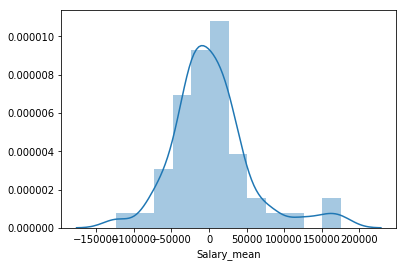

In [53]:
#Checking distribution of residuals
sns.distplot(residuals, bins=12)

The residuals of the target variable are slightly positively skewed but are still reasonably close to a normal distribution.

In [54]:
residuals.shape

(52,)

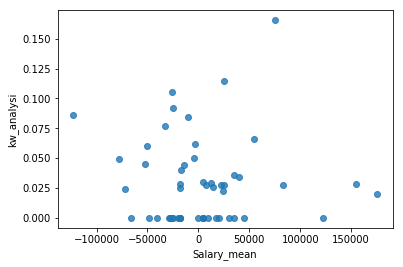

In [55]:
#Check for homoscedasticity.
sns.regplot(residuals, X_test['kw_analysi'], fit_reg=False)

Plotting residuals against various predictor variables doesn't show any obvious signs of heteroscedasticity, as there is no clear
trend in the residuals as these variables increase. Suggesting the assumptions of linear regression aren't violated.

We handled multicollinearity by excluding the variables with the highest correlation above. So it seems that the assumptions of 
linear regression are not violated here and that this is not the problem with my model.

While the model is clearly over-fit to the training data, in order to properly evaluate how well it performs in general we need 
to compare its performance to a dummy regressor model.

In [56]:
from sklearn.dummy import DummyRegressor

In [57]:
dr = DummyRegressor()
dr.fit(Xsub_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [58]:
print('dummy r2: ', get_r2(dr, Xsub_test, y_test))
print('model r2: ', get_r2(optimalenet, Xsub_test, y_test))

dummy r2:  -0.019712708100408927
model r2:  -0.24117485928933502


D:\ANACONDA\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'predicted values')

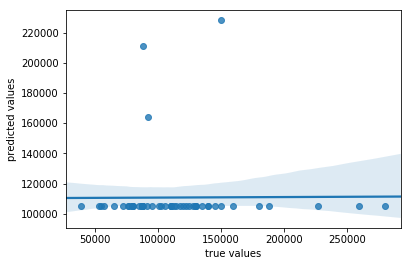

In [59]:
sns.regplot(y_test, y_hat)
plt.xlabel('true values')
plt.ylabel('predicted values')

In comparison to the dummy regressor, my linear model is performing relatively well, making predictions roughly 40% better than 
a baseline naive estimate.

### Modelling -- Classification techniques.

Regression modelling led to some interesting observations, but I had some doubts about the efficacy of the model. Given the 
discontinuous distribution of the salary data, is it easier to predict salary if we define three categories: low, medium and high?

In [68]:
#Create a function to classify salary as high (2), medium (1) or low (0)
def salary_classifier(salary):
    if salary > 120000:
        c = 2
    elif salary > 80000:
        c = 1
    else:
        c = 0
    return c

In [71]:
#Create a new column by applying this function to the mean salary column
jobs_subset['Salary_class'] = jobs_subset['Salary_mean'].apply(salary_classifier)

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
#Are the classes balanced?
jobs_subset['Salary_class'].value_counts()

1    46
2    33
0    25
Name: Salary_class, dtype: int64

In [74]:
#What's the baseline accuracy?
baseline = len(jobs_subset[jobs_subset['Salary_class'] == 1]) / len(jobs_subset['Salary_class'])
baseline

0.4423076923076923

### Defining new variables -- Salary Class

In [75]:
#Define new predictor variable
y = jobs_subset['Salary_class']

In [77]:
#Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 11, stratify=jobs_subset['Salary_class'])

In [78]:
#Standardise X_train/X_test
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

D:\ANACONDA\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\ANACONDA\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### Model 1 -- KNN 

In [79]:
#Conduct a GridSearch to find optimal hyperparameters for KNN
knn_params = {'n_neighbors':[1,3,5,9,15,18,21,25],
             'weights':['uniform','distance'],
             'metric':['euclidean','manhattan']}
knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_gs.fit(X_train, y_train)

D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 9, 15, 18, 21, 25], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [80]:
#Fit a K-nearest neighbours model
knn = knn_gs.best_estimator_
print(knn_gs.best_params_)

{'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}


In [81]:
#Compare knn model accuracy to baseline
knn_pred = knn.predict(X_test)
knn_score = knn.score(X_test, y_test)
print('model accuracy: ', knn.score(X_test, y_test))
print('baseline accuracy: ', baseline)

model accuracy:  0.34615384615384615
baseline accuracy:  0.4423076923076923


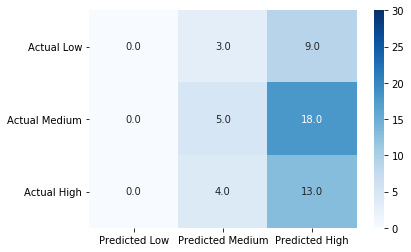

In [82]:
cm1 = confusion_matrix(y_test, knn_pred)
sns.heatmap(cm1, annot=True, fmt = '.1f', cmap = 'Blues', vmax = 30, vmin = 0, 
            xticklabels = ['Predicted Low','Predicted Medium','Predicted High'], 
            yticklabels = ['Actual Low', 'Actual Medium', 'Actual High'])

The KNN model accuracy is slightly better than baseline.

### Model 2 -- Support Vector machine

In [83]:
#Gridsearch for optimal hyperparameters
svm = SVC()
gammas = np.logspace(-5, 2, 20)
Cs = np.logspace(-3, 2, 10)
kernels = ['rbf', 'sigmoid', 'linear', 'poly']
params = dict(gamma=gammas, C=Cs, kernel=kernels)
svm_gs = GridSearchCV(svm, params, cv=5, scoring='accuracy')
svm_gs.fit(X_train, y_train)

D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': array([1.00000e-05, 2.33572e-05, 5.45559e-05, 1.27427e-04, 2.97635e-04,
       6.95193e-04, 1.62378e-03, 3.79269e-03, 8.85867e-03, 2.06914e-02,
       4.83293e-02, 1.12884e-01, 2.63665e-01, 6.15848e-01, 1.43845e+00,
       3.35982e+00, 7.84760e+00, 1.83298e+01, 4.28133e+01, 1.00....15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02]), 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [84]:
svm_best = svm_gs.best_estimator_
print(svm_gs.best_params_)

{'C': 2.1544346900318843, 'gamma': 0.0006951927961775605, 'kernel': 'rbf'}


In [85]:
svm_pred = svm_best.predict(X_test)
svm_score = svm_best.score(X_test, y_test)
print('model accuracy: ', svm_best.score(X_test, y_test))
print('baseline accuracy: ', baseline)

model accuracy:  0.36538461538461536
baseline accuracy:  0.4423076923076923


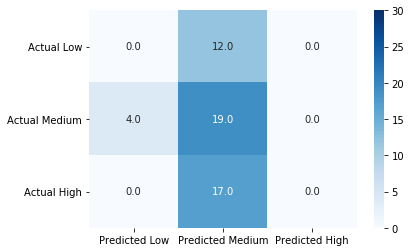

In [86]:
cm1 = confusion_matrix(y_test, svm_pred)
sns.heatmap(cm1, annot=True, fmt = '.1f', cmap = 'Blues', vmax = 30, vmin = 0, 
            xticklabels = ['Predicted Low','Predicted Medium','Predicted High'], 
            yticklabels = ['Actual Low', 'Actual Medium', 'Actual High'])

### Model 3 -- Decision Trees

In [87]:
#Gridsearch again for hyperparameters
params = {'max_depth':[3,4,5],
         'max_leaf_nodes':[2,3,4],
         'min_samples_split':[2,3,4,5,10,15,25],
         'max_features':[5,10,50,100,500]}
dtc_gs = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
dtc_gs.fit(X_train, y_train)

D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [3, 4, 5], 'max_leaf_nodes': [2, 3, 4], 'min_samples_split': [2, 3, 4, 5, 10, 15, 25], 'max_features': [5, 10, 50, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [88]:
dtc = dtc_gs.best_estimator_
print(dtc_gs.best_params_)

{'max_depth': 4, 'max_features': 500, 'max_leaf_nodes': 2, 'min_samples_split': 3}


In [89]:
dtc_pred = dtc.predict(X_test)
dtc_score = dtc.score(X_test, y_test)
print('model accuracy: ', dtc.score(X_test, y_test))
print('baseline accuracy: ', baseline)

model accuracy:  0.4423076923076923
baseline accuracy:  0.4423076923076923


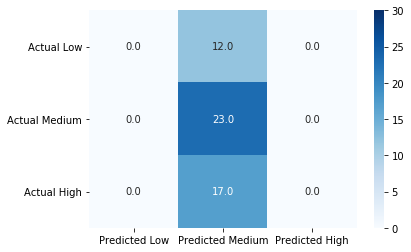

In [90]:
cm1 = confusion_matrix(y_test, dtc_pred)
sns.heatmap(cm1, annot=True, fmt = '.1f', cmap = 'Blues', vmax = 30, vmin = 0, 
            xticklabels = ['Predicted Low','Predicted Medium','Predicted High'], 
            yticklabels = ['Actual Low', 'Actual Medium', 'Actual High'])

### Model 4 -- Bagging Classifier

In [91]:
#With bagging
bag = BaggingClassifier(dtc, max_samples=1.0,random_state=5)
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=500, max_leaf_nodes=2, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
         random_state=5, verbose=0, warm_start=False)

In [92]:
bag_pred = bag.predict(X_test)
bag_score = bag.score(X_test, y_test)
print('model accuracy: ', bag.score(X_test, y_test))
print('baseline accuracy: ', baseline)

model accuracy:  0.4230769230769231
baseline accuracy:  0.4423076923076923


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.45      0.87      0.60        23
           2       0.25      0.12      0.16        17

   micro avg       0.42      0.42      0.42        52
   macro avg       0.23      0.33      0.25        52
weighted avg       0.28      0.42      0.32        52



D:\ANACONDA\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ANACONDA\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ANACONDA\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


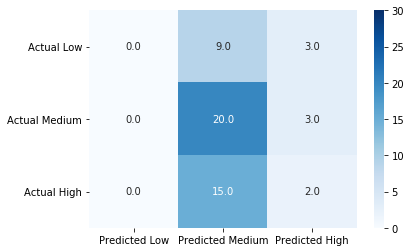

In [93]:
cm1 = confusion_matrix(y_test, bag_pred)
sns.heatmap(cm1, annot=True, fmt = '.1f', cmap = 'Blues', vmax = 30, vmin = 0, 
            xticklabels = ['Predicted Low','Predicted Medium','Predicted High'], 
            yticklabels = ['Actual Low', 'Actual Medium', 'Actual High'])
print(classification_report(y_test,bag_pred))

### Model 5 -- Random Forrest classifier

In [94]:
rf_params = {'n_estimators': [5,10,15,30,50],
            'max_features':[5,20,50,100,250,500],
            'min_samples_leaf':[1,5,10],
            'min_samples_split':[2,5,20,25]
            }

rf_gs = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_gs.fit(X_train, y_train)
rf = rf_gs.best_estimator_
print(rf_gs.best_params_)

{'max_features': 20, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 10}


D:\ANACONDA\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [95]:
rf_pred = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
print('model accuracy: ', rf.score(X_test, y_test))
print('baseline accuracy: ', baseline)

model accuracy:  0.5192307692307693
baseline accuracy:  0.4423076923076923


D:\ANACONDA\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ANACONDA\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ANACONDA\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.49      0.96      0.65        23
           2       0.71      0.29      0.42        17

   micro avg       0.52      0.52      0.52        52
   macro avg       0.40      0.42      0.35        52
weighted avg       0.45      0.52      0.42        52



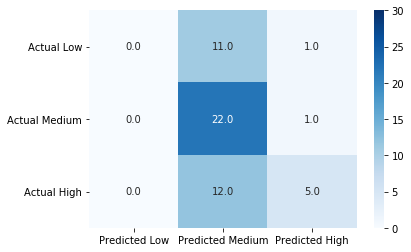

In [96]:
cm1 = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm1, annot=True, fmt = '.1f', cmap = 'Blues', vmax = 30, vmin = 0, 
            xticklabels = ['Predicted Low','Predicted Medium','Predicted High'], 
            yticklabels = ['Actual Low', 'Actual Medium', 'Actual High'])
print(classification_report(y_test,rf_pred))

### Classification model summary

In [121]:
models = ['KNN','SVM','DecisionTree','Bagging','RandomForest','Baseline']
accuracy = [knn_score, svm_score, dtc_score, bag_score,rf_score, baseline]
class_summary = pd.DataFrame({'Model':models, 'Accuracy':accuracy})
class_summary = class_summary.set_index('Model')

In [122]:
class_summary

,Accuracy
Model,
KNN,0.346154
SVM,0.365385
DecisionTree,0.442308
Bagging,0.423077
RandomForest,0.519231
Baseline,0.442308


OBSV : Random Forrest gave the highest accuracy with an ensemble bagging classifier achieving the second-highest accuracy.I would investigate further which are the importance features for Random Forrest further.

In [241]:
importance = rf.feature_importances_
importance_df = pd.DataFrame({'feature':X.columns, 'importance':importance}).sort_values('importance', ascending= False)
importance_df.head(10)

,feature,importance
217,kw_au,0.044463
108,kw_candid,0.041677
120,kw_drive,0.038194
128,kw_base,0.033333
65,kw_process,0.033333
538,kw_view,0.032732
40,kw_analyt,0.028606
59,kw_servic,0.028094
228,kw_thi,0.024381
114,kw_relat,0.022855


OBSV : Both 'learning' in the job title and 'model' in the job summary appear to be important for classifying the salary level of the 
job, suggesting that carrying out machine learning and modelling affects the level of pay. 'Scientist' also appears in the list,
suggesting that perhaps data scientist jobs (where one would likely be doing more machine learning) are typically in a different
pay grade to other jobs. The keyword 'head' also appears, unsurprisingly, suggesting that leadership positions also have an 
impact on salary class.

In [118]:
#Export to a .csv file for use in question 2
filename = 'jobs_part3_complete.csv'
jobs_full.to_csv(filename)